In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

NUMBER_OF_CLASSES=5
BATCH_SIZE=32 # using minibatch of 32 samples

gabriel_features = np.genfromtxt('../data/processed/train_combined_features.csv', skip_header=True, dtype=float, delimiter=',')
y = tf.one_hot(indices=gabriel_features[:,0], depth=NUMBER_OF_CLASSES).numpy()
X = gabriel_features[:,1:]

X = X / X.max(axis=0) # alongside rows, per column

print(X.shape, y.shape)
number_of_features = X.shape[1]

np.random.seed(42)

2025-01-01 20:04:38.696981: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(10000, 121) (10000, 5)


In [2]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)

Big question:
* Is it worthwhile to center data?
* Is it worthwhile to scale data or normalize to (0, 1) range?
For later!


EDIT:
First answer: FOR RELU YOU NEED TO SCALE FOR (0,1) AND FOR TANH FOR (-1,1) OTHERWISE IT WON'T WORK!

In [3]:
input_shape = (number_of_features,) # need to pass that comma, as otherwise it'd be evaluated as simple int i.e. type((5))==int, type((4,))==tuple
model = tf.keras.Sequential(
    [
    tf.keras.Input(shape=input_shape),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
       tf.keras.layers.Dense(units=NUMBER_OF_CLASSES, activation='softmax', kernel_initializer='glorot_normal')
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 121)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,285 (192.52 KB)

 Trainable params: 49,285 (192.52 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=0.0, nesterov=True), # stochastic gradient descent, but can specify batch size.
    loss='categorical_crossentropy',
    metrics=['AUC'],
)

# Train the model with the checkpoint callback
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE, 
    epochs=64,
    callbacks=[checkpoint_callback]
)

Epoch 1/64


/Users/mpj-projects/repositories/classification-Fashion-MNIST/.venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


234/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.6197 - loss: 1.6850
Epoch 1: val_loss improved from inf to 1.22523, saving model to best_model.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6247 - loss: 1.6710 - val_AUC: 0.8692 - val_loss: 1.2252
Epoch 2/64
239/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.7689 - loss: 1.3160
Epoch 2: val_loss improved from 1.22523 to 1.11686, saving model to best_model.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7691 - loss: 1.3153 - val_AUC: 0.8594 - val_loss: 1.1169
Epoch 3/64
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7983 - loss: 1.2452
Epoch 3: val_loss improved from 1.11686 to 1.06355, saving model to best_model.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7985 - loss: 1.2447 - val_AUC: 0.8719 - val_loss: 1.0636
Epoch 4/64
245/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.8122 - loss: 1.2077
Epoch 4: val_loss improved from 1.06355 to 0.99136, saving model to best_model.weights.h5
250/250 ━━

In [ ]:
history.history.keys()

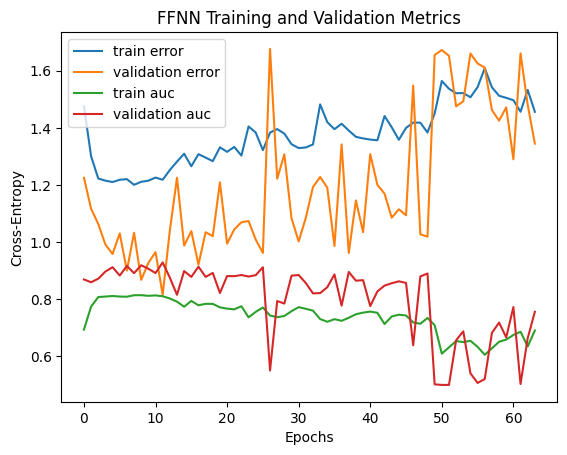

In [8]:


plt.figure()
plt.plot(history.history['loss'], label='train error')
plt.plot(history.history['val_loss'], label='validation error')
plt.plot(history.history['AUC'], label='train auc')
plt.plot(history.history['val_AUC'], label='validation auc')
plt.title('FFNN Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

### Evaluation

In [11]:

gabriel_features = np.genfromtxt('../data/processed/test_combined_features.csv', skip_header=True, dtype=float, delimiter=',')
y = tf.one_hot(indices=gabriel_features[:,0], depth=NUMBER_OF_CLASSES).numpy()
X = gabriel_features[:,1:]

X = X / X.max(axis=0) # alongside rows, per column

print(X.shape, y.shape)
number_of_features = X.shape[1]

np.random.seed(42)

(5000, 121) (5000, 5)


In [12]:
# load model from checkpoint best_model.weights.h5
model.load_weights('best_model.weights.h5')
# evaluate the model
loss, auc = model.evaluate(X, y)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.9178 - loss: 0.8548


In [ ]:

data = np.load('../data/raw/fashion_test.npy')
X = data[:, :-1]
y = data[:, -1]

X = X / X.max(axis=0) # alongside rows, per column
# fill nans with zeros
X = np.nan_to_num(X)
y = tf.one_hot(indices=y, depth=NUMBER_OF_CLASSES).numpy()


results = model.evaluate(X, y, batch_size=32)

print('test results:', results)

In [10]:
model.save('../models/v0.01_reference_nn.keras')

# CNN

In [ ]:
from sklearn.model_selection import train_test_split
data = np.load('../data/raw/fashion_train.npy')
X = data[:, :-1]
y = data[:, -1]

X = X / X.max(axis=0) # alongside rows, per column
y = tf.one_hot(indices=y, depth=NUMBER_OF_CLASSES).numpy()


X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)
unique_labels = np.unique(y)
unique_labels

In [ ]:
X.shape

In [ ]:

# Define the neural network architecture
model = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)),
        tf.keras.layers.Conv2D(
            16, kernel_size=3, strides=1, padding="same", activation="relu"
        ),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(
            32, kernel_size=3, strides=1, padding="same", activation="relu"
        ),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)

# Print model architecture
model.summary()

# Compile the model
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True), # stochastic gradient descent, but can specify batch size.
    loss='categorical_crossentropy',
    metrics=['AUC'],
)


# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=7,
    batch_size=32,
)
results = model.evaluate(X_val, y_val, batch_size=32)
import matplotlib.pyplot as plt

In [ ]:

plt.figure()
plt.plot(history.history['loss'], label='train error')
plt.plot(history.history['val_loss'], label='validation error')
plt.plot(history.history['auc'], label='train auc')
plt.plot(history.history['val_auc'], label='validation auc')
plt.title('CNN Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

## Evaluation of CNN on the test set.

In [ ]:
data = np.load('../data/raw/fashion_test.npy')
X = data[:, :-1]
y = data[:, -1]

X = X / X.max(axis=0) # alongside rows, per column
# fill nans with zeros
X = np.nan_to_num(X)
y = tf.one_hot(indices=y, depth=NUMBER_OF_CLASSES).numpy()


results = model.evaluate(X, y, batch_size=32)

print('test results:', results)